MIT License

Copyright (c) 2024 Mohannad Shehadeh

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

This notebook provides a [Julia](https://julialang.org/) model for a complete encoder–decoder pair for unterminated [Higher-Order Staircase Codes](https://arxiv.org/pdf/2410.16504) that are [multiply-chained](https://doi.org/10.1109/TCOMM.2022.3185065) and with the extended Hamming component codes described [here](https://arxiv.org/pdf/2312.13415). For fast simulation, you should instead use [decsim-mc-hosc](https://github.com/fkschischang/decsim) which is intended to simulate a statistically equivalent process, but is orders of magnitude faster. For codes without multiple chaining, i.e., $C = 1$, you can instead use [hosc-Julia](https://github.com/applecoffeecake/hosc-Julia).

In [1]:
# Required packages; install if missing
using DataStructures
using Dates
using Plots
using DelimitedFiles

In [2]:
include("GF2-LinAlg.jl");
include("L-one-two-DTSs.jl");
include("grab-DTS.jl");

# Multiply-Chained Higher-Order Staircase Codes: Overview and Conventions

- We begin with a special choice of $L\times (M+1)$ delays given by $$0 = d_0^{(\ell)} < d_1^{(\ell)} < \cdots < d_M^{(\ell)}$$ for 
$\ell \in \{0,1,\dots,L-1\}$. We further have that $$\mathsf{SCOPE} = d_M^{(0)} > d_M^{(1)} > \cdots > d_M^{(L-1)}\text{.}$$ 
The optimal delays (minimizing encoding and decoding memory while guaranteeing [scattering](https://arxiv.org/pdf/2312.13415)) are extremely difficult to find in general except when $M\in\{1,2\}$ in which case there is an explicit construction. The optimal delays for $M\in \{3,4\}$ were found for some values of $L$ in [Higher-Order Staircase Codes](https://arxiv.org/pdf/2312.13415) and are included in this repository and imported by this notebook. You can participate in the search for more optimal delay values using the tool [dts-search](https://github.com/applecoffeecake/dts-search) described in [Higher-Order Staircase Codes](https://arxiv.org/pdf/2312.13415) and other tools referenced therein.

- We also have
$M+1$ special permutations $\pi_k(i,j)$ for $k \in \{0,1,\dots,M\}$ where $i,j\in \{0,1,\dots,T-1\}$. Unlike the delays, the optimal permutations (guaranteeing [scattering](https://arxiv.org/pdf/2312.13415)) have an easy explicit algebraic construction. The $T \times T$ matrix $B$ with entries $b_{(i,j)}$ permuted according to $\pi_k$ has entries given by $b_{\pi_k(i,j)}$ and is denoted by $\Pi_k(B)$. Moreover, we have $\Pi_0(B) = B$. Note that that this convention for what it means to permute a matrix according to $\pi_k$ is important in our construction because **the forward and inverse permutations are not interchangeable**.

- We have $T \times T$ blocks $B^{(n,c,\ell)}$ for $n\in\mathbb{Z}$, $c \in \{0,1,\dots,C-1\}$, and $\ell \in \{0,1,\dots,L-1\}$ which 
are arranged into $CT \times LT$ rectangles that are transmitted. The $n$th rectangle is given by
$$
\begin{pmatrix}
    B^{(n,C-1,L-1)} & B^{(n,C-1,L-2)} & \cdots & B^{(n,C-1,0)}\\
    B^{(n,C-2,L-1)} & B^{(n,C-2,L-2)} & \cdots & B^{(n,C-2,0)}\\
            \vdots & \vdots & \ddots & \vdots \\
    B^{(n,0,L-1)} & B^{(n,0,L-2)} & \cdots & B^{(n,0,0)}
\end{pmatrix}
= 
\big(\text{ $CT \times (LT-r)$ information bits} \;\big\vert\; \text{ $CT \times r$ parity bits}\big)
$$
which yields a rate of $1-r/(LT)$.

- The encoding rule is as follows. The rows of the $CT \times ((M+1)LT)$ matrix
$$
\begin{pmatrix}
\Pi_M(B^{(n-d_M^{(L-1)},C-2,L-1)}) & \cdots &\Pi_M(B^{(n-d_M^{(1)},C-2,1)}) & \Pi_M(B^{(n-d_M^{(0)},C-2,0)}) & \cdots & \Pi_1(B^{(n-d_1^{(L-1)},C-2,L-1)}) & \cdots & \Pi_1(B^{(n-d_1^{(1)},C-2,1)}) & \Pi_1(B^{(n-d_1^{(0)},C-2,0)}) & B^{(n,C-1,L-1)} & \cdots & B^{(n,C-1,1)} & B^{(n,C-1,0)}\\
\Pi_M(B^{(n-d_M^{(L-1)},C-3,L-1)}) & \cdots &\Pi_M(B^{(n-d_M^{(1)},C-3,1)}) & \Pi_M(B^{(n-d_M^{(0)},C-3,0)}) & \cdots & \Pi_1(B^{(n-d_1^{(L-1)},C-3,L-1)}) & \cdots & \Pi_1(B^{(n-d_1^{(1)},C-3,1)}) & \Pi_1(B^{(n-d_1^{(0)},C-3,0)}) & B^{(n,C-2,L-1)} & \cdots & B^{(n,C-2,1)} & B^{(n,C-2,0)}\\
                            \vdots & \ddots &                        \vdots &                         \vdots & \ddots &                             \vdots & \ddots &                         \vdots &                         \vdots &          \vdots & \ddots &        \vdots & \vdots \\
\Pi_M(B^{(n-d_M^{(L-1)},0,L-1)}) & \cdots &\Pi_M(B^{(n-d_M^{(1)},0,1)}) & \Pi_M(B^{(n-d_M^{(0)},0,0)}) & \cdots & \Pi_1(B^{(n-d_1^{(L-1)},0,L-1)}) & \cdots & \Pi_1(B^{(n-d_1^{(1)},0,1)}) & \Pi_1(B^{(n-d_1^{(0)},0,0)}) & B^{(n,1,L-1)} & \cdots & B^{(n,1,1)} & B^{(n,1,0)}\\
\Pi_M(B^{(n-d_M^{(L-1)},C-1,L-1)}) & \cdots &\Pi_M(B^{(n-d_M^{(1)},C-1,1)}) & \Pi_M(B^{(n-d_M^{(0)},C-1,0)}) & \cdots & \Pi_1(B^{(n-d_1^{(L-1)},C-1,L-1)}) & \cdots & \Pi_1(B^{(n-d_1^{(1)},C-1,1)}) & \Pi_1(B^{(n-d_1^{(0)},C-1,0)}) & B^{(n,0,L-1)} & \cdots & B^{(n,0,1)} & B^{(n,0,0)}
\end{pmatrix}
$$
must belong to some specified component code of length $(M+1)LT$ and dimension $(M+1)LT-r$. In this notebook, we use extended Hamming component codes. The collection of $CT$ component codeword constraints applying to the rows of above matrix is referred to as a *constraint span chain*.

- The above constraint span chain is labeled as the $(n-\mathsf{SCOPE})$th constraint span chain. The $c$th *link* of the $(n-\mathsf{SCOPE})$th contraint span chain is the portion of constraints applying to the rows of
$$
\begin{pmatrix}
\Pi_M(B^{(n-d_M^{(L-1)},c-1\pmod C,L-1)}) & \cdots &\Pi_M(B^{(n-d_M^{(1)},c-1\pmod C,1)}) & \Pi_M(B^{(n-d_M^{(0)},c-1\pmod C,0)}) & \cdots & \Pi_1(B^{(n-d_1^{(L-1)},c-1\pmod C,L-1)}) & \cdots & \Pi_1(B^{(n-d_1^{(1)},c-1\pmod C,1)}) & \Pi_1(B^{(n-d_1^{(0)},c-1\pmod C,0)}) & B^{(n,c,L-1)} & \cdots & B^{(n,c,1)} & B^{(n,c,0)}
\end{pmatrix}
$$
and is referred to as the $(n-\mathsf{SCOPE},c)$th *constraint span*.

- For the block $B^{(n,c,\ell)}$, the $M+1$ involved constraint spans are the $(n-\mathsf{SCOPE},c)$th and the $(n-\mathsf{SCOPE}+d_i^{(\ell)}, c+1 \pmod C)$th for $i \in \{1,2,\dots, M\}$.

- If we have a decoding window (or circular buffer) of $W$ rectangles, we maintain a circular buffer of $W$ groups of $CT$ syndromes corresponding to $W$ constraint span chains. The first $W-\mathsf{SCOPE}$ of these correspond to complete constraint span chains in the decoding window. The last $\mathsf{SCOPE}$ of these correspond to partial syndromes calculated from the portion of the constraint span chains that are in the decoding window and will be completed by future rectangles.

- When $T \neq 1$, you must choose $M$ to be less than or equal to the least prime factor of $T$. It is possible to have more flexibility with the values of $M$ and $T$ if required as illustrated [here](https://github.com/applecoffeecake/hosc-interleaver-maps) and you can easily implement it here by copying and adapting my Julia code from there. But I don't implement it here because I want to avoid the prime power finite field arithmetic involved.
- However, when $T = 1$, you are allowed to choose any $M$.

In [3]:
# You must choose M to be less than or equal to the least prime factor of T if T is not equal to 1
# to get a proper higher-order staircase code with the right error floor performance.
# However, when T = 1, you are allowed to choose any M.
L = 4
T = 2
M = 2
C = 3

# Load the matrix of delay values "DTS" 
# Currently supported L and M are:
# If M = 1: all L 
# If M = 2: all L
# If M = 3: all L up to 15
# If M = 4: all L up to 10 excluding 9
# If M = 5,6,7,8,9: L = 1
DTS = grabDTS(L,M)

SCOPE = maximum(DTS)

# Decoding window size in number of CT x LT rectangles:
# Suggested value is 2*(1+SCOPE) to 5*(1+SCOPE)
W = 3*(1+SCOPE)

# Number of decoding iterations
ITERS = 1

m = ceil(Int64, log2(L*T*(M+1)))
s = 2^m - (M+1)*L*T;
n = (M+1)*L*T;
k = n-(m+1);
@assert m+1 < L*T
@assert W >= 1+SCOPE
println("L = $L")
println("T = $T")
println("M = $M")
println("C = $C")
println("SCOPE = $SCOPE")
println("W = $W rectangles = $(W*C*T*L*T/1e6) Mbits" )
println("ITERS = $ITERS")
println("rate = $(1-(m+1)/(L*T))")
println("component code dimension/length k/n = $k/$n")
println("number of parity bits (or parity columns in a block) m+1 = $(m+1)")

L = 4
T = 2
M = 2
C = 3
SCOPE = 12
W = 39 rectangles = 0.001872 Mbits
ITERS = 1
rate = 0.25
component code dimension/length k/n = 18/24
number of parity bits (or parity columns in a block) m+1 = 6


In [4]:
# # CREATE C language static array DTS definitions for use with descim-hosc
# MAX_L_IN_EXPLICIT_CASE = 1000;
# L_M_SET = [(L,1) for L in 1:MAX_L_IN_EXPLICIT_CASE];
# L_M_SET = [L_M_SET; [(L,2) for L in 1:MAX_L_IN_EXPLICIT_CASE]];
# L_M_SET = [L_M_SET; [(L,3) for L in 1:15]];
# L_M_SET = [L_M_SET; [(L,4) for L in [1,2,3,4,5,6,7,8,10]]];
# L_M_SET = [L_M_SET; [(1,M) for M in [5,6,7,8,9]]];
# C_DTS_config = "";
# for lmpair in L_M_SET
#     local L = lmpair[1];
#     local M = lmpair[2];
#     local DTS = grabDTS(L,M);
#     local SCOPE_MINUS_DTS_c = reverse(maximum(DTS) .- DTS,dims=1);
#     C_DTS_config *= 
#     (L==1 && M==1 ? "#" : "#el")* 
#     "if (L == $L && M == $M)
#         //static const int DTS[L][M+1] = " *
#         "{"*prod(["{"*prod(string.(DTS[j,:]) .* [i == M+1 ? "" : "," for i in 1:M+1])*"}" for j in 1:L] .* 
#     [i == L ? "" : "," for i in 1:L])*"};
#         static const int SCOPE_MINUS_DTS_c[L][M+1] = " *
#         "{"*prod(["{"*prod(string.(SCOPE_MINUS_DTS_c[j,:]) .* [i == M+1 ? "" : "," for i in 1:M+1])*"}" for j in 1:L] .* 
#     [i == L ? "" : "," for i in 1:L])*"};
#         #define SCOPE $(maximum(DTS))
# "
# end
# C_DTS_config *= "#endif"
# write("dts-defs.h",C_DTS_config)

In [5]:
# The following creates a systematic extended Hamming code 
# generator matrix G, parity-check matrix H, its transpose Ht,
# and the parity/non-identity portion of the generator matrix P
# This is a special choice of systematic extended Hamming code
# with a LUT-free decoding method described in the Higher-Order
# Staircase Codes paper.

# m a b ainv
special_eHamming = 
[
3 1 1 1;  
4 3 0  11;
5 3 0  11;
6 3 3  43;
7 5 5  77;
8 9 11  57;
9 19 19  27;
10 27 27  531;
11 53 53  541;
12 89 89  2025;
13 163 170  4875;
14 301 308  13989;
15 553 553  14873;
16 1065 1155 55321;
]
if (m < 3 || m > 16)
    throw("Unsupported m!")
end
a = special_eHamming[m-3+1,2]
b = special_eHamming[m-3+1,3] + a*s
ainv = special_eHamming[m-3+1,4]
mask = (1<<m)-1
minus_b = (1<<m)-b

synFromErrorloc(x) = (((a*x+b)&mask)<<1)+1
errorlocFromSyn(x) = (ainv*((x>>1)+minus_b))&mask

H = zeros(Int64,m+1,0)
for i in 0:n-1
    H = hcat(H,reverse(digits(synFromErrorloc(i),base=2,pad=m+1))) 
end

@assert [errorlocFromSyn(synFromErrorloc(x)) for x in 0:n-1] == 0:n-1
@assert [synFromErrorloc(errorlocFromSyn(2*x+1)) for x in 0:n-1] == 2 .* (0:n-1) .+ 1

G = RREF(dual(H));

Id_kk = Int64.(ones(k,k)^0)
@assert G[1:k,1:k] == Id_kk;
@assert sum(mod.(G*transpose(H),2)) == 0;
P = G[:,k+1:n];
Ht = transpose(H);

Note that a more memory-efficient encoder architecture is possible than the one modeled here.

In [6]:
TX_buffer = CircularBuffer{Matrix{Int64}}(W); # TX buffer for error counting
RX_buffer = CircularBuffer{Matrix{Int64}}(W); # Decoder buffer
Syn_buffer = CircularBuffer{Matrix{Int64}}(W); # Decoder buffer
ENC_buffer = CircularBuffer{Matrix{Int64}}(SCOPE); # Encoder buffer

In [7]:
function reset_buffers()
    for i in 1:W
        push!(TX_buffer, zeros(Int64,C*T,L*T))
        push!(RX_buffer, zeros(Int64,C*T,L*T))
        push!(Syn_buffer, zeros(Int64,C*T,m+1))
    end
    for i in 1:SCOPE
        push!(ENC_buffer, zeros(Int64,C*T,L*T))
    end
end;
reset_buffers();

I provide two permutation options. For more on the permutation options, refer to the relevant parts of [the notebook here](https://github.com/applecoffeecake/hosc-interleaver-maps).

In [8]:
# l = 0,1,...,M

# π_1(l,i,j) = l == 0 ? i : (j-1)+1;
# π_2(l,i,j) = l == 0 ? j : mod((i-1)+(l-1)*(j-1), T) + 1;
# π_inv_1(l,i,j) = l == 0 ? i : mod(-(l-1)*(i-1) + (j-1), T) + 1;
# π_inv_2(l,i,j) = l == 0 ? j : (i-1) + 1;

π_1(l,i,j) = l == 0 ? i : mod.(-(l-1)*(i-1) + (j-1), T) + 1;
π_2(l,i,j) = l == 0 ? j : mod.((1-(l-1)^2)*(i-1) + (l-1)*(j-1), T) + 1;
π_inv_1(l,i,j) = l == 0 ? i : mod.(-(l-1)*(i-1) + (j-1), T) + 1;
π_inv_2(l,i,j) = l == 0 ? j : mod.((1-(l-1)^2)*(i-1) + (l-1)*(j-1), T) + 1;

In [9]:
Π(l,B) = [B[π_1(l,i,j), π_2(l,i,j)] for i in 1:T, j in 1:T];
Π_inv(l,B) = [B[π_inv_1(l,i,j), π_inv_2(l,i,j)] for i in 1:T, j in 1:T];

In [10]:
TEST_MAT = [j + T*i + 1 for i in 0:T-1, j in 0:T-1];
@assert sum([Π_inv(l,Π(l,TEST_MAT)) == TEST_MAT for l in 0:M]) == M+1
@assert sum([Π(l,Π_inv(l,TEST_MAT)) == TEST_MAT for l in 0:M]) == M+1

In [11]:
# Encode a uniformly random CT x LT-(m+1) info rectangle, push CT x LT result to ENC_buffer
function encode()
    B_info = rand(0:1,C*T,L*T-(m+1)); # CT x LT-(m+1)
    B_parity = B_info*P[k-(L*T-(m+1)-1):k,:] # CT x LT-(m+1) and LT-(m+1) x (m+1) yields CT x (m+1) 
    for c in 0:C-1 # chain link index
        for u in 1:M # delay/perm index
            for ℓ in 0:L-1 # class index
                B_parity[1+(C-c-1)*T:T+(C-c-1)*T,:] += Π(u,ENC_buffer[end+1-DTS[ℓ+1,u+1]][1+(C-mod(c-1,C)-1)*T:T+(C-mod(c-1,C)-1)*T,1+(L-ℓ-1)*T:T+(L-ℓ-1)*T])*P[n-T+1-T*(L*u+ℓ):n-T*(L*u+ℓ),:]
            end
        end
    end
    B = [B_info mod.(B_parity, 2)];
    push!(ENC_buffer, B)
end;

In [12]:
# Push clean copy of newest rectangle in ENC_buffer to TX_buffer
# Push a noisy copy to RX_buffer with crossover probability p
# Push an all zero CT x (m+1) group of partial syndromes to Syn_buffer 
function transmit(p) 
    push!(TX_buffer, ENC_buffer[end])
    push!(RX_buffer, ENC_buffer[end] .⊻ (rand(C*T,L*T) .<= p))
    push!(Syn_buffer, zeros(Int64,C*T,m+1))
end;

In [13]:
# Update update M + 1 partial syndromes going as far back as SCOPE from
# the end of the syndrome buffer and completing one syndrome group
function update_Syn()
    for c in 0:C-1 # chain link index
        for u in 0:M # delay/perm index
            for ℓ in 0:L-1 # class index
                if (u == 0)
                    Syn_buffer[end-SCOPE+DTS[ℓ+1,u+1]][1+(C-c-1)*T:T+(C-c-1)*T,:] .⊻= mod.(Π(u,RX_buffer[end][1+(C-c-1)*T:T+(C-c-1)*T,1+(L-ℓ-1)*T:T+(L-ℓ-1)*T])*Ht[n-T+1-T*(L*u+ℓ):n-T*(L*u+ℓ),:],2)
                else
                    Syn_buffer[end-SCOPE+DTS[ℓ+1,u+1]][1+(C-c-1)*T:T+(C-c-1)*T,:] .⊻= mod.(Π(u,RX_buffer[end][1+(C-mod(c-1,C)-1)*T:T+(C-mod(c-1,C)-1)*T,1+(L-ℓ-1)*T:T+(L-ℓ-1)*T])*Ht[n-T+1-T*(L*u+ℓ):n-T*(L*u+ℓ),:],2)
                end
            end
        end
    end
end;

In [14]:
# reset_buffers()

In [15]:
# encode()
# transmit(0.0)
# update_Syn()

In [16]:
# Syn_buffer

In [17]:
function flip(rect, c, ℓ, i, j)
    RX_buffer[rect][(C-1-c)*T + i, (L-1-ℓ)*T + j] ⊻= 1
    for u = M:-1:0
        if rect-SCOPE+DTS[ℓ+1,u+1] > 0 
            i_perm, j_perm = π_inv_1(u,i,j), π_inv_2(u,i,j)
            if (u == 0)
                Syn_buffer[rect-SCOPE+DTS[ℓ+1,u+1]][(C-1-c)*T + i_perm,:] .⊻= Ht[((M-u)*L+(L-1-ℓ))*T+j_perm,:] 
            else
                Syn_buffer[rect-SCOPE+DTS[ℓ+1,u+1]][(C-1-mod(c+1,C))*T + i_perm,:] .⊻= Ht[((M-u)*L+(L-1-ℓ))*T+j_perm,:] 
            end
        end
    end
end;

In [18]:
# reset_buffers()

In [19]:
# encode()
# transmit(0.0)
# update_Syn()

In [20]:
# flip(4,1,0,1,1)

In [21]:
# flip(4,0,1,2,1)

In [22]:
# Syn_buffer

In [23]:
# sweep()

In [24]:
# RX_buffer

In [25]:
# count_errors() = sum(TX_buffer[1][:,1:L*T-(m+1)] .!= RX_buffer[1][:,1:L*T-(m+1)]);
count_errors() = sum(TX_buffer[1] .!= RX_buffer[1]);

In [26]:
integer_basis = [2^i for i in m:-1:0]';
function sweep()
    for w in (W-SCOPE):-1:1
        for c in 0:C-1
            for i in 1:T
                if Syn_buffer[w][(C-1-c)*T + i, m+1] != 0 
                    errorloc = errorlocFromSyn(integer_basis*Syn_buffer[w][(C-1-c)*T + i,:]) + 1;
                    if errorloc <= n
                        j_rect = (errorloc-1)%(L*T) + 1
                        perm = M - div(errorloc-1, L*T)
                        ℓ = L-1-div(j_rect-1, T);
                        j = (j_rect-1)%T + 1;
                        if (perm == 0)
                            flip(w+SCOPE-DTS[ℓ+1,perm+1], c, ℓ, π_1(perm, i, j), π_2(perm, i, j))
                        else
                            flip(w+SCOPE-DTS[ℓ+1,perm+1], mod(c-1,C), ℓ, π_1(perm, i, j), π_2(perm, i, j))
                        end
                    end
                end          
            end
        end
    end
end;

In [27]:
# Specify vector ps of crossover probabilities to simulate
# and vector TRIALS of respective numbers of trials for each crossover probability
ps =     [  4, 4.5,   5, 5.5,   6, 6.5,   7, 7.5,   8]*1e-2
TRIALS = [2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e5, 2e5, 2e5] 
# TRIALS = Int64(2e6)*ones(Int64,length(ps))
# TRIALS = Int64(1e2)*ones(Int64,length(ps))
display(ps')
display(TRIALS')
@assert length(ps) == length(TRIALS)

1×9 adjoint(::Vector{Float64}) with eltype Float64:
 0.04  0.045  0.05  0.055  0.06  0.065  0.07  0.075  0.08

1×9 adjoint(::Vector{Float64}) with eltype Float64:
 2.0e6  2.0e6  2.0e6  2.0e6  2.0e6  2.0e6  200000.0  200000.0  200000.0

In [28]:
tot = sum(TRIALS); # Total number of trials for progress tracking
percent_increment = round(Int64,tot/100) == 0 ? 1 : round(Int64,tot/100);

In [29]:
BERs = zeros(length(ps))
err_cts = zeros(Int64,length(ps))
tracker = 0
t_0 = now()
for point in 1:length(ps)
    reset_buffers();
    for trial in 1:TRIALS[point]   
        tracker += 1
        if tracker%percent_increment == 0
            percentage = round(Int64,tracker/tot*100)
            if percentage%1 == 0
                println("Progress: $percentage%")
                println("Errors for parameter p = $(ps[point]): $(err_cts[point])")
            end
        end
        encode();
        transmit(ps[point]);
        update_Syn();
        for iter in 1:ITERS
            sweep();
        end
        # Delay of W before starting error counting
        if trial > W
            err_cts[point] += count_errors();
        end     
    end
end
t_1 = now()

Progress: 1%
Errors for parameter p = 0.04: 34
Progress: 2%
Errors for parameter p = 0.04: 86
Progress: 3%
Errors for parameter p = 0.04: 114
Progress: 4%
Errors for parameter p = 0.04: 142
Progress: 5%
Errors for parameter p = 0.04: 176
Progress: 6%
Errors for parameter p = 0.04: 220
Progress: 7%
Errors for parameter p = 0.04: 228
Progress: 8%
Errors for parameter p = 0.04: 255
Progress: 9%
Errors for parameter p = 0.04: 287
Progress: 10%
Errors for parameter p = 0.04: 319
Progress: 11%
Errors for parameter p = 0.04: 364
Progress: 12%
Errors for parameter p = 0.04: 396
Progress: 13%
Errors for parameter p = 0.04: 418
Progress: 14%
Errors for parameter p = 0.04: 456
Progress: 15%
Errors for parameter p = 0.04: 474
Progress: 16%
Errors for parameter p = 0.045: 10
Progress: 17%
Errors for parameter p = 0.045: 34
Progress: 18%
Errors for parameter p = 0.045: 86
Progress: 19%
Errors for parameter p = 0.045: 138
Progress: 20%
Errors for parameter p = 0.045: 184
Progress: 21%
Errors for para

2024-10-25T17:42:35.834

In [30]:
K = C*T*(L*T-(m+1));
println("Simulation duration in different units:")
println(round((t_1 - t_0), Dates.Second(1)))
println(round((t_1 - t_0), Dates.Minute(1)))
println(round((t_1 - t_0), Dates.Hour(1)))
println()
dur_in_ms = (t_1 - t_0).value
dur_in_ms_avg = (dur_in_ms/tot)
println("$tot trials or blocks transmitted")
println("$(tot*K*1e-6) Mbits transmitted")
println("$dur_in_ms_avg milliseconds per trial")
throughput = K/dur_in_ms_avg/1e-3/1e6
println("throughput: $throughput Mbit/s")

Simulation duration in different units:
1979 seconds
33 minutes
1 hour

1.26e7 trials or blocks transmitted
151.2 Mbits transmitted
0.1570270634920635 milliseconds per trial
throughput: 0.07641994783024461 Mbit/s


In [31]:
err_cts'

1×9 adjoint(::Vector{Int64}) with eltype Int64:
 486  727  1259  2208  4087  10283  4244  17557  81686

In [32]:
# 1.0 ./ ((TRIALS .- W)*K)'

In [33]:
ps'

1×9 adjoint(::Vector{Float64}) with eltype Float64:
 0.04  0.045  0.05  0.055  0.06  0.065  0.07  0.075  0.08

In [34]:
BERs = err_cts ./ ((TRIALS .- W)*K);
BERs'

1×9 adjoint(::Vector{Float64}) with eltype Float64:
 2.02504e-5  3.02923e-5  5.24594e-5  …  0.00176868  0.00731684  0.0340425

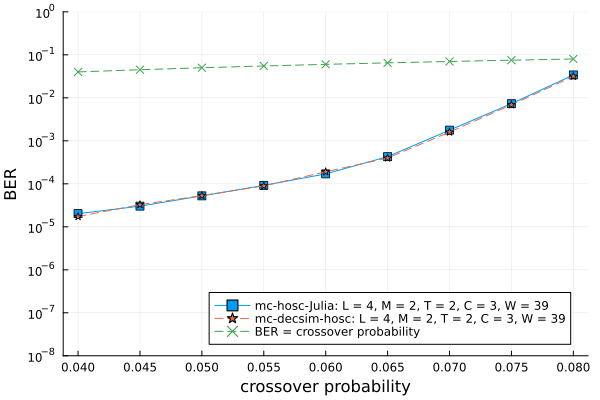

In [35]:
plot(ps, BERs, marker=:rect, yaxis=:log, legend=:bottomright, label="mc-hosc-Julia: L = $L, M = $M, T = $T, C = $C, W = $W")
plot!([4,4.5,5,5.5,6,6.5,7,7.5,8]*1e-2,[1.73333e-05,3.26667e-05,5.3125e-05,8.92917e-05,0.000190417,0.000397458,0.00159292,0.00688833,0.0315775],
    mark=:s,linestyle=:dash,label="mc-decsim-hosc: L = 4, M = 2, T = 2, C = 3, W = 39")
plot!(ps,ps,marker=:x,line=:dash,label="BER = crossover probability")
ylims!(1e-8,1e-0)
yticks!([10.0^(-i) for i in 0:9])
ylabel!("BER")
xticks!(ps)
xlabel!("crossover probability")
